# Author disambiguation

Find a way of performing fuzzy matches across authors.

Input:

- Spreadsheet or CSV which contains a single column of authors per publication, typically with a "; " separator

Output:

- List of name pairings with fuzzy scores
- List of name families with a primary name, so that a substitution of auxiliary names can be performed

This ended up being an interesting look in to the performance of combinatory tasks, and as such pulls in a bunch of extra libraries as part of that curiosity-driven exploration as I figured things out along the way.

### To do list

- [x] Download sample file
- [x] Load in sample file
- [x] Research maths of number of combos to estimate big O 
- [x] Create first pass of code for generating pairs, all that jazz
- [x] Wrap up code to date as functions, considering possible args for customisation
- [x] Alter author list splitter to optionally produce table of first, last authors
- [ ] Save pair scores to Excel for manual vetting, perhaps add in column for manual decisions
- [ ] Load up manual results from Excel
- [ ] Create families of names for substitutions (might involve some nasty loops)
- [ ] Take original list of RCRs, spin out RCR <-> author rows
- [ ] Substitute secondary names with primary
- [ ] Perform aggregrations based on cleansed primary names


## Imports and config

In [1]:
import os
import openpyxl
import functools
import matplotlib
import math
import operator as op
import pandas as pd

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

Note that in this pipenv environment python-Levenshtein is installed, so fuzzywuzzy should be more performant and not flag warnings about speed.

In [2]:
%matplotlib inline

In [3]:
DATA_DIR = os.path.join(".", "data")

## Get sample author names

In [4]:
os.listdir(DATA_DIR)

['sample_pubs.csv']

In [5]:
# Old spreadsheet version - left in for reference if wanting to read XLSX files
# spreadsheet = pd.read_excel('top_1pc_pubs.xslx', sheet_name='12-16 top 1%')
# author_lists = spreadsheet['Authors']
# author_lists = author_lists.str.split("; ")

In [6]:
file_path = os.path.join(DATA_DIR, 'sample_pubs.csv')
sample_pubs = pd.read_csv(file_path, index_col='PMID', encoding='latin1')
author_lists = sample_pubs['Authors']
author_lists = author_lists.str.split("; ")

In [7]:
type(author_lists)

pandas.core.series.Series

In [8]:
names = set()
for auth_list in author_lists:
    for auth in auth_list:
        if len(auth) > 2:
            names.add(auth)
names

{'Seth Flaxman',
 'Rahul Gupta',
 'Stalin E Ewoigbokhan',
 'Richard Humbert',
 'Shih-Yi Lin',
 'Darren Ware',
 'Jordana T. Bell',
 'Janet Seeley',
 'Francesca Demarchi',
 'Catherine Snow',
 'Jia Fan',
 'Tino Kurz',
 'Craig M Walsh',
 'Lina Keller',
 'Thomas Gasser',
 'Yoshitaka Takano',
 'Kristen Lee',
 'A. Patricia Bento',
 'T. Tukiainen',
 'Shih-Hwa Chiou',
 'John Kent Lin',
 'M E Peter',
 'Zeb Haradon',
 'Mohammad A Almazroa',
 'Sarah Tosato',
 'Christine M. Freitag',
 'Razibuzzaman Shah',
 'Faris H Al Lami',
 'Nadine Steckling',
 'Gilbert S Omenn',
 'G\x9fnter Raddatz',
 'Madeline A. Lancaster',
 'Christian Kieling',
 'David H Kessel',
 'Anthony O. Shafer',
 'Marcus D\x9arr',
 'J-C Martinou',
 'S. Morin',
 'Ejaz A Khan',
 'Antoni Ribas',
 'Vasco Manuel Pedro Machado',
 'Nicole C Lockhart',
 'Deborah A. Nickerson',
 'Karin Fransen',
 'Ida Surakka',
 'M.L. Andermann',
 'Vinay Nangia',
 'Simon Brent',
 'Christopher A. Walsh',
 'E Filipa de Castro',
 'Julien E. Gautrot',
 'Christopher 

In [9]:
len(names)

9268

#### Create the function

Wrap that up in a function:

In [10]:
def load_pubs(csv, pmid_column='PMID', author_column='Authors', encoding='latin1'):
    """Takes input CSV plus options, returns a pandas Series of PMIDs linked to lists of authors"""
    sample_pubs = pd.read_csv(file_path, index_col='PMID', encoding='latin1')
    author_lists = sample_pubs['Authors']
    author_lists = author_lists.str.split("; ")
    return(author_lists)

In [11]:
def extract_authors(author_lists, method="all"):
    names = set()
    for auth_list in author_lists:
        if method == "all":
            auth_list = auth_list
        elif method =="ends":
            auth_list = [auth_list[0], auth_list[-1]]
        elif method =="first":
            auth_list = [auth_list[0]]
        elif method =="last":
            auth_list = [auth_list[-1]]
        
        for auth in auth_list:
            if len(auth) > 2:
                names.add(auth)
    return(names)

In [12]:
sample_author_lists = load_pubs(os.path.join(DATA_DIR, 'sample_pubs.csv'))

In [13]:
all_names = extract_authors(sample_author_lists, method="all")
list(all_names)[0:10] # preview them

['Seth Flaxman',
 'Rahul Gupta',
 'Stalin E Ewoigbokhan',
 'Richard Humbert',
 'Shih-Yi Lin',
 'Darren Ware',
 'Jordana T. Bell',
 'Janet Seeley',
 'Francesca Demarchi',
 'Catherine Snow']

In [14]:
first_authors = extract_authors(sample_author_lists, method="first")

In [15]:
list(first_authors)[0:10]

['Bryan Howie',
 'Ed Bullmore',
 'Patrick F Sullivan',
 'Katie Hampson',
 'Ludmil B. Alexandrov',
 'Ulf Ekelund',
 'Serena Nik-Zainal',
 'Karol Estrada',
 'Gordon D. Brown',
 'Sarah Djebali']

## Construct all pairs

### Aside: let's get an intitution for the maths at scale

Note that we need to generate this many pairs (where $k=2$ and $n=n_{names}$:

$$\frac{n!}{k!(n-k)!}$$

- 18ms to run on 100 samples
- 242ms to run on 1000 samples
- 20s to run on 5000 samples
- 10,000 never finished on my machine

In [16]:
# lets see what the maths looks like
def ncr(n, r):
    r = min(r, n-r)
    numer = functools.reduce(op.mul, range(n, n-r, -1), 1)
    denom = functools.reduce(op.mul, range(1, r+1), 1)
    return numer//denom

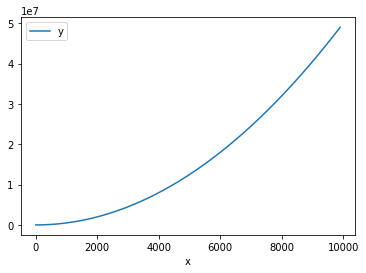

In [17]:
df = pd.DataFrame(columns=['x', 'y'])
for x in range(0, 10000, 100):
    df = df.append({'x': x, 'y': ncr(x, 2)}, ignore_index=True)
df.plot(x="x", y="y")

### Aside over: generate pairs

In [18]:
names_list = list(names)
names_list = names_list[0:101]
pair_list = []

while len(names_list) > 1:
    current_name = names_list.pop()
    for name in names_list:
        pair_list.append((current_name, name))

In [19]:
len(pair_list)

5050

In [20]:
pair_list[0:5]

[('Tuuli Lappalainen', 'Seth Flaxman'),
 ('Tuuli Lappalainen', 'Rahul Gupta'),
 ('Tuuli Lappalainen', 'Stalin E Ewoigbokhan'),
 ('Tuuli Lappalainen', 'Richard Humbert'),
 ('Tuuli Lappalainen', 'Shih-Yi Lin')]

#### Create the function

In [21]:
def generate_pairs(names):
    names_list = names.copy()
    pair_list = []
    while len(names_list) > 1:
        current_name = names_list.pop()
        for name in names_list:
            pair_list.append((current_name, name))
    return(pair_list)

In [22]:
sample_pairs = generate_pairs(first_authors)

In [23]:
sample_pairs[0:5]

[('Bryan Howie', 'Ed Bullmore'),
 ('Bryan Howie', 'Patrick F Sullivan'),
 ('Bryan Howie', 'Katie Hampson'),
 ('Bryan Howie', 'Ludmil B. Alexandrov'),
 ('Bryan Howie', 'Ulf Ekelund')]

## Fuzzy matching

In [24]:
len(sample_pairs)

13861

In [25]:
pair_scores = [[pair[0], pair[1], fuzz.ratio(pair[0], pair[1])] for pair in sample_pairs]

In [26]:
df2 = pd.DataFrame(pair_scores, columns=['name1', 'name2', 'score'])

In [27]:
df2['above_threshold'] = df2.score > 50

In [28]:
df2.sample(5)

,name1,name2,score,above_threshold
1910,Paul Flicek,A. Patrcia Bento,29,False
9628,Kyaw M Tun,Katherine S. Button,41,False
9864,Peter J. Murray,Nicholas J. Croucher,34,False
2673,Nicholas J Kassebaum,Cristen J. Willer,32,False
2169,Susannah J Salter,Juan Antonio Vizcano,32,False


#### Create the function

In [29]:
def fuzzy_match(pairs, threshold=80):
    """takes pairs of names, returns a dataframe of pairs with fuzzy scores"""
    pair_scores = [[pair[0], pair[1], fuzz.ratio(pair[0], pair[1])] for pair in pairs]
    df = pd.DataFrame(pair_scores, columns=['name1', 'name2', 'score'])
    df['above_threshold'] = (df['score'] >= threshold)
    return df

In [30]:
sample_scores = fuzzy_match(sample_pairs)
sample_scores.query("above_threshold")

,name1,name2,score,above_threshold
2576,Nicholas J Kassebaum,Nicholas J. Kassebaum,98,True
3069,Stephen P.H. Alexander,Stephen Ph Alexander,90,True
11898,Juan Antonio Vizcano,Juan A Vizcano,83,True


### Save this to Excel for editing

### Load from Excel for manually verified / denied matches

### Create lists

Families of names that should be treated as equivalent. Check to see if either of current names is any existing list, if not then create one. If it is, append it to that particular list.

In [31]:
families = []
name_pairs = sample_scores.query("above_threshold")

In [32]:
name_pairs.filter(items=["name1", "name2"])

,name1,name2
2576,Nicholas J Kassebaum,Nicholas J. Kassebaum
3069,Stephen P.H. Alexander,Stephen Ph Alexander
11898,Juan Antonio Vizcano,Juan A Vizcano


In [33]:
all_pairs = [[row.name1, row.name2] for index, row in name_pairs.iterrows()]
all_pairs

[['Nicholas J Kassebaum', 'Nicholas J. Kassebaum'],
 ['Stephen P.H. Alexander', 'Stephen Ph Alexander'],
 ['Juan Antonio Vizca\x92no', 'Juan A Vizca\x92no']]

In [34]:
for pair in all_pairs:
    for name in pair:
        # check if it's already in the list of families
        # add them both to a new family if not
        # if one of the two is already in a set, add them both
        pass

Then turn this in to a dict with a primary name as the key for substitutions

### Use this to substitute original author RCR table names

### Perform calculations based on these disambiguated authors